In [13]:
import numpy as np
import subjects

sess = subjects.nsd.ratJday2[0]
print(sess.recinfo)


filename: /data/Clustering/sessions/RatJ/Day2/RatJ_Day2_2019-06-02_03-59-19.xml 
# channels: 67
sampling rate: 30000
lfp Srate (downsampled): 1250


In [9]:
sess.recinfo.skipped_channels


array([0, 2, 6, 5])

## Set probe configuration
Lets create probe configuration for a 128-channel probe

data saved


<AxesSubplot:title={'center':'Probe 64ch'}>

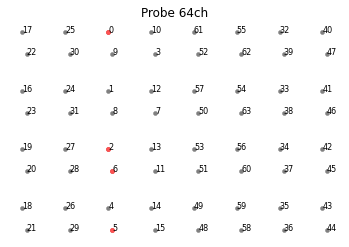

In [10]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe

shanks = []
channel_groups = sess.recinfo.channel_groups
for i in range(8):
    shank = Shank.auto_generate(
        columns=2,
        contacts_per_column=4,
        xpitch=15,
        ypitch=20,
        y_shift_per_column=[0, -7.5],
        channel_id=np.append(
            channel_groups[i][::2][::-1], channel_groups[i][1::2][::-1]
        ),
    )
    shanks.append(shank)
    shank.set_disconnected_channels(sess.recinfo.skipped_channels)

probe1 = Probe(shanks)

prbgrp = ProbeGroup()
prbgrp.add_probe(probe1)

prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save()
plot_probe(prbgrp)

## Create epochs for your experimental paradigm
A typical experiment involves multiple epochs such pre sleep, running on track and then another sleep epoch.

In [11]:
sess.paradigm.to_dataframe()


,start,stop,label,duration
0,0,11146,pre,11146
1,11166,15006,maze,3840
2,15090,57738,post,42648


In [ ]:
import pandas as pd
from neuropy.core import Epoch

epochs = pd.DataFrame(
    {
        "start": [0, 10000, 20000],
        "stop": [9000, 13600, 30000],
        "label": ["pre", "maze", "post"],
    }
)

a = Epoch(epochs=epochs)
a.filename = sess.filePrefix.with_suffix(".paradigm.npy")
# a.save()

# Detect epochs
Here we will various types of epochs which typical for hippocampal recordings.

## Artifacts epochs
A typical session will have some artifacts that may negatively influence many analyses. Using a simple zscore measure, we can identify epochs where signal is above some threshold.

In [ ]:
signal = sess.eegfile.get_signal([1])
artifact_epochs = analyses.detect_artifact_epochs(signal, thresh=7)
artifact_epochs.filename = sess.filePrefix.with_suffix(".artifact.npy")
artifact_epochs.save()
plotting.plot_artifact_epochs(artifact_epochs, signal)

## Ripple epochs
To detect ripples one also needs probegroup.

In [ ]:
from neuropy.analyses import oscillations

signal = sess.eegfile.get_signal()
ripple_epochs = oscillations.detect_ripple_epochs(signal, sess.probegroup)
ripple_epochs.filename = sess.filePrefix.with_suffix(".ripple.npy")
ripple_epochs.save()

In [ ]:
signal = sess.eegfile.get_signal(channel_id=[1, 2, 3, 4], t_start=1, t_stop=1.2)
plotting.plot_signal_traces(signal)


# Importing spiketrains from Phy

In [15]:
from neuropy.io import PhyIO
from neuropy.core import Neurons
from pathlib import Path
import numpy as np

cluster_path = Path(
    "/data/Clustering/sessions/RatJ/Day2/spykcirc/RatJ_Day2_2019-06-02_03-59-19/RatJ_Day2_2019-06-02_03-59-19.GUI"
)

chan_grps = sess.recinfo.channel_groups
phy_data = PhyIO(cluster_path)
spiketrains = phy_data.spiketrains
peak_chans = phy_data.peak_channels
waveforms = phy_data.peak_waveforms
shank_id = sess.probegroup.get_shank_id_for_channels(peak_chans)

neurons = Neurons(
    np.array(spiketrains, dtype=object),
    t_stop=sess.eegfile.duration,
    sampling_rate=phy_data.sampling_rate,
    peak_channels=peak_chans,
    waveforms=np.array(waveforms, dtype="object"),
    shank_ids=np.array(shank_id).astype(int),
)

neurons.filename = sess.filePrefix.with_suffix(".neurons")
neurons.save()

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
from neuropy.plotting import plot_raster


plt.plot(phy_data.peak_waveforms[0])
plot_raster(neurons,color='jet',add_vert_jitter=True)

# BinnedSpiketrain and Mua objects using Neurons

In [18]:
mua = sess.neurons.get_mua()
mua.filename = sess.filePrefix.with_suffix(".mua.npy")
mua.save()

data saved


In [20]:
%matplotlib widget
from neuropy import plotting
smth_mua = sess.mua.get_smoothed(sigma=0.02)
plotting.plot_mua(smth_mua)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [21]:
from neuropy.analyses import detect_pbe_epochs

pbe = detect_pbe_epochs(smth_mua)
pbe.filename = sess.filePrefix.with_suffix(".pbe")
pbe.save()

/home/bapung/miniconda3/envs/data_analysis/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


data saved
